In [45]:
import yfinance as yf
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from datetime import datetime

# Função para baixar os dados das ações
# Função para baixar os dados das ações
def download_stock_data(tech_list, end_date="2024-01-01"):
    company_data = {}
    for stock in tech_list:
        print(f"Downloading data for {stock}")
        company_data[stock] = yf.download(stock, end=end_date)
    return company_data

# Lista de empresas
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN','TSLA','NVDA','META','AMD','BABA','INTC','PYPL','EA']
company_data = download_stock_data(tech_list)

# Consolidar dados
all_data = pd.concat([company_data[ticker]['Adj Close'].rename(ticker) for ticker in tech_list], axis=1)

# Preencher valores faltantes com interpolação
all_data = all_data.interpolate(method='time').fillna(method='bfill').fillna(method='ffill')
print(all_data.head())
print(all_data.size)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


                AAPL      GOOG      MSFT      AMZN      TSLA      NVDA  \
Date                                                                     
1980-03-17  0.099058  2.496292  0.060055  0.097917  1.592667  0.037621   
1980-03-18  0.099058  2.496292  0.060055  0.097917  1.592667  0.037621   
1980-03-19  0.099058  2.496292  0.060055  0.097917  1.592667  0.037621   
1980-03-20  0.099058  2.496292  0.060055  0.097917  1.592667  0.037621   
1980-03-21  0.099058  2.496292  0.060055  0.097917  1.592667  0.037621   

                 META       AMD      BABA      INTC       PYPL        EA  
Date                                                                      
1980-03-17  38.151604  3.145833  90.67395  0.182651  36.709999  0.504963  
1980-03-18  38.151604  3.031250  90.67395  0.181190  36.709999  0.504963  
1980-03-19  38.151604  3.041667  90.67395  0.185573  36.709999  0.504963  
1980-03-20  38.151604  3.010417  90.67395  0.184843  36.709999  0.504963  
1980-03-21  38.151604  2.916667

In [46]:
class StockDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        #x = self.data[idx:idx+self.window_size]
        #y = self.data[idx+self.window_size]
        #return torch.tensor(x.values, dtype=torch.float32), torch.tensor(y.values, dtype=torch.float32)
        x = self.data.iloc[idx:idx+self.window_size].values
        y = self.data.iloc[idx+self.window_size].values
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


window_size = 10
train_size = int(len(all_data) * 0.8)
train_data = all_data[:train_size]
test_data = all_data[train_size:]

train_dataset = StockDataset(train_data, window_size)
test_dataset = StockDataset(test_data, window_size)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [47]:
class StockPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = len(tech_list)
hidden_size = 10
output_size = len(tech_list)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StockPredictor(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [48]:
num_epochs = 10000
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0
    for inputs, targets in train_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_dataloader)}')


Epoch 1/10000, Loss: 1021.2993093297101
Epoch 2/10000, Loss: 1019.1976415661798
Epoch 3/10000, Loss: 1016.1766755477241
Epoch 4/10000, Loss: 1010.4787040378736
Epoch 5/10000, Loss: 1004.6752779311028
Epoch 6/10000, Loss: 999.7316664543705
Epoch 7/10000, Loss: 996.2974658910779
Epoch 8/10000, Loss: 993.5697428385416
Epoch 9/10000, Loss: 991.0710785354393
Epoch 10/10000, Loss: 988.788254889889
Epoch 11/10000, Loss: 986.579125445822
Epoch 12/10000, Loss: 984.4601413892663
Epoch 13/10000, Loss: 982.4057776409646
Epoch 14/10000, Loss: 980.3430520762568
Epoch 15/10000, Loss: 978.3321170530457
Epoch 16/10000, Loss: 976.3856103869452
Epoch 17/10000, Loss: 974.41345480214
Epoch 18/10000, Loss: 972.4993896484375
Epoch 19/10000, Loss: 970.6307417275249
Epoch 20/10000, Loss: 968.7649323836616
Epoch 21/10000, Loss: 966.884960229846
Epoch 22/10000, Loss: 965.0304052380548
Epoch 23/10000, Loss: 962.777633888134


Test Loss for apple: 7939.813161640927


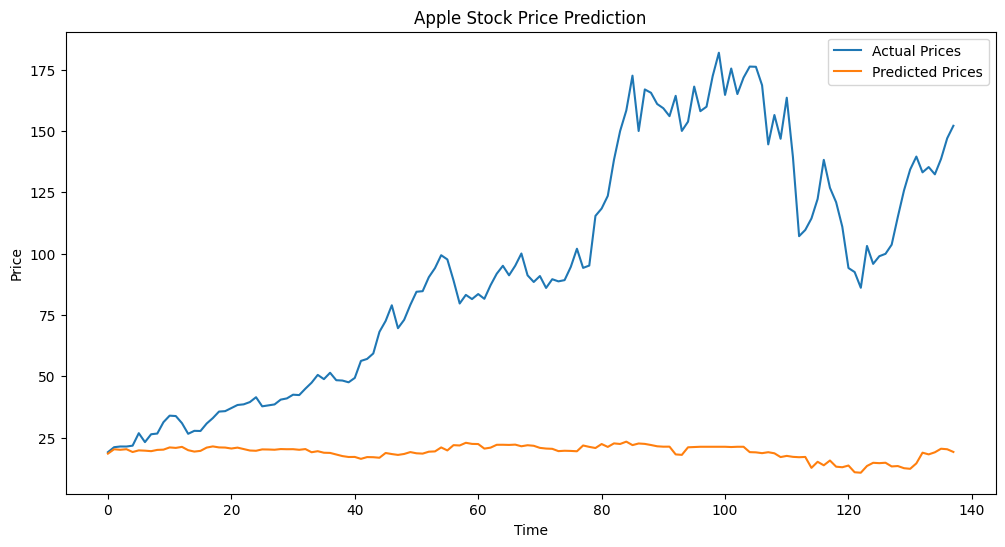

In [ ]:
model.eval()
amazon_index = tech_list.index('AMZN')

test_losses = []
actuals = []
predictions = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs[:, amazon_index], targets[:, amazon_index])
        test_losses.append(loss.item())

        actuals.append(targets[0, amazon_index].item())
        predictions.append(outputs[0, amazon_index].item())

print(f'Test Loss for apple: {sum(test_losses)/len(test_losses)}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual Prices')
plt.plot(predictions, label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Apple Stock Price Prediction')
plt.legend()
plt.show()

#erro de 7939 na amazon
